In [1]:
import scipy.io as spio
import numpy as np
import matplotlib.pyplot as plt
from numpy import inf

from __future__ import division
import numpy as np
from sklearn import  preprocessing
from sklearn.metrics import roc_auc_score
# import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


USE_PARTIAL_DATA = 0
SEED = 12
BLOCK_SIZE = 10

/Users/ehalekote/miniconda3/envs/ML2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loading data...
data loaded
[1.2794     1.23022306 1.18104367 1.13180875 1.0825557  1.03339383
 0.98417845 0.93497537 0.88574953 0.83653077 0.78734276 0.73814537
 0.68892922 0.63972599]


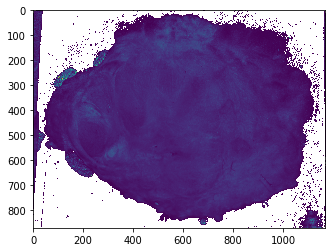

loading data...
data loaded
[1.2794     1.23022306 1.18104367 1.13180875 1.0825557  1.03339383
 0.98417845 0.93497537 0.88574953 0.83653077 0.78734276 0.73814537
 0.68892922 0.63972599]


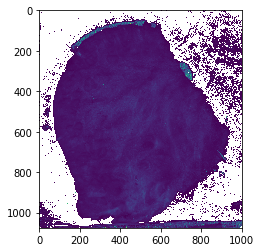

In [2]:
def extract_wave(filename):
    print "loading data..."

    data = spio.loadmat(filename, squeeze_me=True)

    print "data loaded"

    #I_AC_ALL contains reflection information matrix and the freqs that were measures
    matrix = data['I_AC_ALL']
    freq = data['sfx']
    print freq

    matrix = np.asarray(matrix)

    #matrix indices are (x,y,color,freq)

    #Work with just the first color for now
    wave = matrix[:,:,0,:]

    #plot an example image at just one frequency
    image = wave[:,:,4]
    plt.imshow(image)
    plt.show()
    
    return wave


cancer_wave = extract_wave('data/I_AC_ALL0a.mat')
control_wave = extract_wave('data/I_AC_ALL0b.mat')


In [3]:
def remove_infs(x):
    x[x == -inf] = 0
    x[x == inf] = 0
    x[np.isnan(x)] = 0
    return x
    


#Extract sections with cancer and sections without cancer
cancer = cancer_wave[350:550, 500:700, :]
cancer = remove_infs(cancer)

not_cancer = control_wave[200:900, 250:550, :]
not_cancer = remove_infs(not_cancer)

In [4]:
print cancer_wave.shape
print cancer.shape
cancer = cancer.reshape((cancer.shape[0] * cancer.shape[1], not_cancer.shape[2]))

not_cancer = not_cancer.reshape((not_cancer.shape[0] * not_cancer.shape[1],not_cancer.shape[2]))

X = np.vstack((cancer, not_cancer))

y = [1] * len(cancer) + [0] * len(not_cancer)

(870, 1170, 14)
(200, 200, 14)


In [5]:
"""
Fit models and make predictions.
We'll use one-hot encoding to transform our categorical features
into binary features.
y and X will be numpy array objects.
"""

def bagged_set(X_t,y_c,model, myseed, estimators, xt, update_seed=True):
    
    # create array object to hold predictions 
    baggedpred=[ 0.0  for d in range(0, (xt.shape[0]))]
    #loop for as many times as we want bags
    for n in range (0, estimators):
        #shuff;e first, aids in increasing variance and forces different results
        #X_t,y_c=shuffle(Xs,ys, random_state=seed+n)

        if update_seed: # update seed if requested, to give a slightly different model
            model.set_params(seed=myseed + n)
        model.fit(X_t,y_c) # fit model0.0917411475506
        preds=model.predict_proba(xt)[:,1] # predict probabilities
        # update bag's array

        baggedpred+=preds
    # divide with number of bags to create an average estimate            

    baggedpred = np.true_divide(baggedpred,float(estimators))
    # return probabilities            
    return np.array(baggedpred) 

filename="LR" # nam prefix
#model = linear_model.LogisticRegression(C=3)  # the classifier we'll use

model=RandomForestClassifier(max_depth=2, random_state=0)

# === load data in memory === #
print "loading data"


if USE_PARTIAL_DATA == 1:
    X, X_discard, y, y_discard = train_test_split(X, y, train_size=PERCENT_DATA, random_state=42)




#create arrays to hold cv an dtest predictions
train_stacker=[ 0.0  for k in range (0,(X.shape[0])) ] 

# === training & metrics === #
mean_auc = 0.0
bagging=5 # number of models trained with different seeds
n = 5  # number of folds in strattified cv
kfolder=StratifiedKFold(y, n_folds= n,shuffle=True, random_state=SEED)     
i=0
for train_index, test_index in kfolder: # for each train and test pair of indices in the kfolder object
    # creaning and validation sets
    X_train, X_cv = X[train_index], X[test_index]
    y_train, y_cv = np.array(y)[train_index], np.array(y)[test_index]
    #print (" train size: %d. test size: %d, cols: %d " % ((X_train.shape[0]) ,(X_cv.shape[0]) ,(X_train.shape[1]) ))

    # if you want to perform feature selection / hyperparameter
    # optimization, this is where you want to do it

    # train model and make predictions 
    #preds=bagged_set(X_train,y_train,model, SEED , bagging, X_cv, update_seed=False)
    
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_cv)[:,1]


    # compute AUC metric for this CV fold
    roc_auc = roc_auc_score(y_cv, preds)
    print "AUC (fold %d/%d): %f" % (i + 1, n, roc_auc)
    mean_auc += roc_auc

    no=0
    for real_index in test_index:
             train_stacker[real_index]=(preds[no])
             no+=1
    i+=1

loading data
AUC (fold 1/5): 0.822544
AUC (fold 2/5): 0.816620
AUC (fold 3/5): 0.822874
AUC (fold 4/5): 0.819126
AUC (fold 5/5): 0.819844


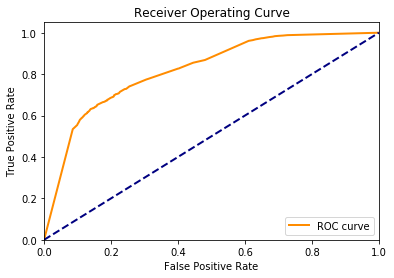

 Average AUC: 0.820202


In [6]:
fpr, tpr, _ = roc_curve(y_cv, preds)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')
plt.legend(loc="lower right")
plt.show()
    
    
mean_auc/=n
print (" Average AUC: %f" % (mean_auc) )
# print (" printing train datasets ")
# printfilcsve(np.array(train_stacker), filename + ".train.csv")          

In [7]:
# === Predictions === #
# When making predictions, retrain the model on the whole training set
model.fit(X,y)

training_error = roc_auc_score(y, model.predict_proba(X)[:,1])

print training_error

0.8213499983333333


In [8]:
#Find the predictions
test_matrix = remove_infs(cancer_wave)
X_test = test_matrix.reshape((test_matrix.shape[0] * test_matrix.shape[1], test_matrix.shape[2]))
preds = model.predict_proba(X_test)[:,1]

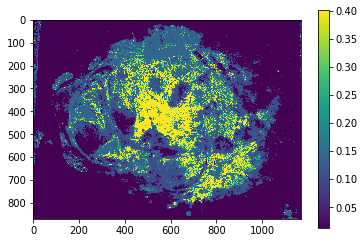

In [9]:
#Put them in a displayable format

n, m, _ = test_matrix.shape

heatmap = preds.reshape((n,m))
# heatmap = np.clip(heatmap, 0, 0.06)
plt.imshow(heatmap)
plt.colorbar()
plt.show()